# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

# Read in data

In [2]:
AirPassengers = pd.read_csv('AirPassengers.csv')
AirPassengers.head()

Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

# Data Management

In [3]:
from datetime import datetime
AirPassengers['Month'] = pd.to_datetime(AirPassengers['Month'], format='%Y-%m')
AirPassengers.head()

Month  #Passengers
0 1949-01-01          112
1 1949-02-01          118
2 1949-03-01          132
3 1949-04-01          129
4 1949-05-01          121

In [4]:
AirPassengers.set_index('Month', inplace=True)
AirPassengers.head()

#Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121

In [5]:
AirPassengers['#Passengers'] = pd.to_numeric(AirPassengers['#Passengers'])
print(AirPassengers.describe())

       #Passengers
count   144.000000
mean    280.298611
std     119.966317
min     104.000000
25%     180.000000
50%     265.500000
75%     360.500000
max     622.000000


In [6]:
AirPassengers.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [7]:
#Specify the entire range:
AirPassengers['1949-01-01':'1949-05-01']

#Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121

In [8]:
#Use ':' if one of the indices is at ends:
AirPassengers[:'1949-05-01']

#Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121

In [9]:
AirPassengers['1949']

#Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121
1949-06-01          135
1949-07-01          148
1949-08-01          148
1949-09-01          136
1949-10-01          119
1949-11-01          104
1949-12-01          118

# 1. Visualise Time Series

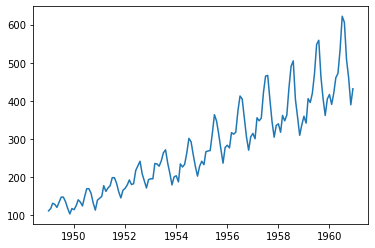

In [10]:
%matplotlib inline
plt.plot(AirPassengers)

In [11]:
AirPassengers['Month'] = AirPassengers.index.month
AirPassengers.head()

#Passengers  Month
Month                         
1949-01-01          112      1
1949-02-01          118      2
1949-03-01          132      3
1949-04-01          129      4
1949-05-01          121      5

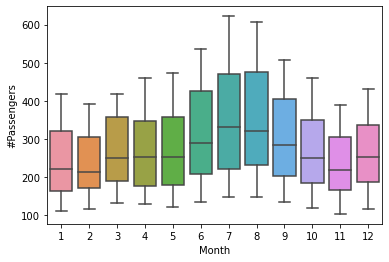

In [12]:
import seaborn as sns
ax = sns.boxplot(data = AirPassengers, x='Month',y='#Passengers')

# 2. Stationarity  - Check

In [13]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
 
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)  

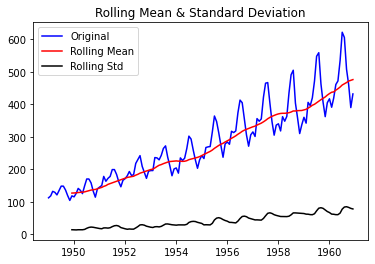

In [14]:
test_stationarity(AirPassengers['#Passengers'])

In [15]:
from statsmodels.tsa.stattools import adfuller

#Perform Dickey-Fuller test:
def test_Dickey_Fuller(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [16]:
test_Dickey_Fuller(AirPassengers['#Passengers'])

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


# Make Time Series Stationary

# Decomposing

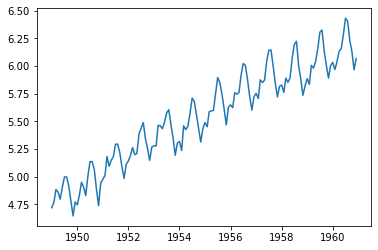

In [17]:
ts_log = np.log(AirPassengers['#Passengers'])
plt.plot(ts_log)

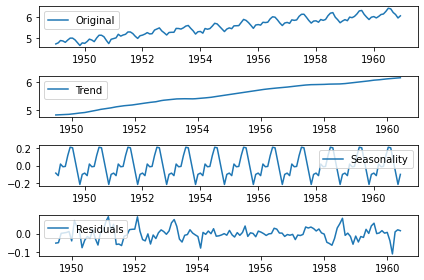

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_log)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

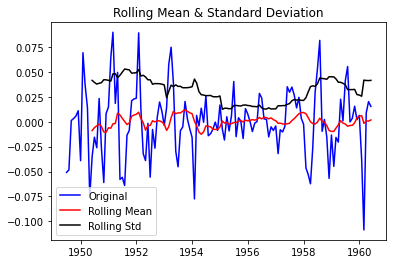

In [19]:
#use only residual data
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

In [20]:
test_Dickey_Fuller(ts_log_decompose)

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


# Plot ACF & PACF chart & find optimal parameter

In [21]:
from statsmodels.tsa.stattools import acf, pacf

In [22]:
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

C:\Users\jc790999\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


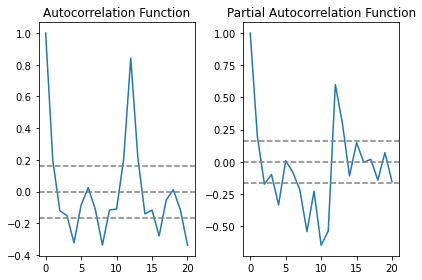

In [23]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

# Build ARIMA model

In [24]:
from statsmodels.tsa.arima_model import ARIMA

C:\Users\jc790999\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jc790999\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


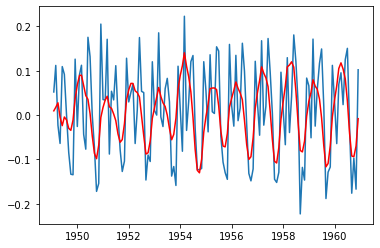

In [25]:
#ARIMA
model = ARIMA(ts_log, order=(2, 1, 2))  #(p,d,q)
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')

# Make predictions

In [26]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)

In [27]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()

In [28]:
predictions_ARIMA_log = pd.Series(ts_log[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)

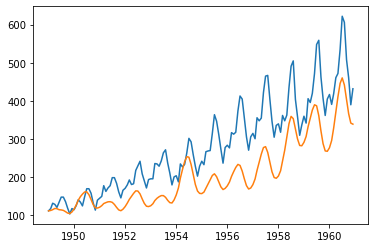

In [29]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(AirPassengers['#Passengers'])
plt.plot(predictions_ARIMA)